# 3.4 Linear Regression Implementation from Scratch


## 1. What would happen if we were to initialize the weights to zero. Would the algorithm still work? What if we initialized the parameters with variance `1000` rather than `0.01`?

Copy the implementation of the linear regression from scratch, modify the w to torch.zeros()

In [10]:
from d2l import torch as d2l
import torch

class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        # self.w = torch.zeros((num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)
        
    def forward(self, X):
        return torch.matmul(X, self.w) + self.b
    
    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2 / 2
        return l.mean()
    
    def configure_optimizers(self):
        return SGD([self.w, self.b], self.lr)
    

define the model, data, trainer, and start training

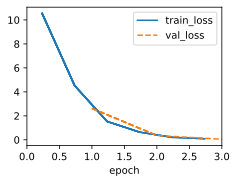

In [11]:
# model = LinearRegressionScratch(2, lr=0.03, sigma=0.01)
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

As we can see, the algorithm still works. 

When you use a convex cost function (has only one minima), you can initialize your weights to zeros and still reach the minima. The reason is that you’ll have just a single optimal point and it does not matter where you start by initializing the weights. Though, the starting point may change the epochs it takes to reach optimum you are bound to reach it. On the other hand in neural networks with the hidden layers the cost function doesnt have one single optimum and in that case to break the symmetry we don’t want to use same weights.

When the variance is 1000 rather than 0.01, the loss is much larger.

Due to the large variance, the parameter(weight) is more likely to deviate from the the expectation, which is often 0. So the parameter is more likely to have a large absolute value, resulting in a larger y_hat, thus a larger loss.

Meanwhile, the gradient is larger too. The gradient value is related to y, y_hat, weight, bias and each layer's output, when one of them is larger, the gradient is larger.

## 2. Assume that you are Georg Simon Ohm trying to come up with a model for resistance that relates voltage and current. Can you use automatic differentiation to learn the parameters of your model?

Of course. I think it's viable to let voltage be ouput and current be input or vice versa.

## 3. Can you use [Planck's Law](https://en.wikipedia.org/wiki/Planck%27s_law) to determine the temperature of an object using spectral energy density? For reference, the spectral density $B$ of radiation emanating from a black body is $B(\lambda, T) = \frac{2 hc^2}{\lambda^5} \cdot \left(\exp \frac{h c}{\lambda k T} - 1\right)^{-1}$. Here $\lambda$ is the wavelength, $T$ is the temperature, $c$ is the speed of light, $h$ is Planck's constant, and $k$ is the Boltzmann constant. You measure the energy for different wavelengths $\lambda$ and you now need to fit the spectral density curve to Planck's law.

Of course, let $\lambda$ and B be the input of the neural network, and T be the output.

We can train a network to approximate the mapping function $T=f(B, \lambda)$ by minimizing the mean squared error (MSE) between the predicted output and the true output.

## 4. What are the problems you might encounter if you wanted to compute the second derivatives of the loss? How would you fix them?

According to the information on the net, there are two ways to calc second derivative:

1. backward()
2. torch.autograd.grad()

Let's start from backward(), which is more familiar to us.

In [15]:
import torch

x = torch.arange(5, dtype=torch.float32, requires_grad=True)
y = torch.dot(x, x)

In [17]:
if x.grad is not None:
    x.grad.zero_()
y.backward(create_graph=True) # According to Pytorch documentation, create_graph=True is necessary for second-order gradients.
print("first backward: ", x.grad)
y.backward(retain_graph=True)
print("second backward: ", x.grad)

first backward:  tensor([0., 2., 4., 6., 8.], grad_fn=<CopyBackwards>)
second backward:  tensor([ 0.,  4.,  8., 12., 16.], grad_fn=<CopyBackwards>)


When $y = ||x||^2 = x^T x, \nabla y = 2x$, so $\nabla^2 y = 2I$(unit vector or matrix)

As we can see above, the second backward result is not correct. So I can't believe that backward() can calc second derivative.

Next, let's validate another method: autograd.grad()

In [18]:
if x.grad is not None:
    x.grad.zero_() # clear previous gradients
dydx = torch.autograd.grad(y, x, create_graph=True)[0] # create_graph=True will construct the graph of the derivative, allowing to comput higher order derivative products.
print(dydx) # dydx is a 1d vector
# only can calculate derivative of scalar
d2ydx2 = torch.autograd.grad(dydx.sum(), x, create_graph=True)[0] # summation won't affect the differentiation result
print(d2ydx2)

tensor([0., 2., 4., 6., 8.], grad_fn=<AddBackward0>)
tensor([2., 2., 2., 2., 2.])


As we can see, the result of autograd.grad is correct.

The documentation of autograd.grad: https://pytorch.org/docs/stable/generated/torch.autograd.grad.html

[Second derivative fails if first derivative happens to be constant](https://github.com/pytorch/pytorch/issues/32304)

## 5. Why is the `reshape` method needed in the `loss` function?

To avoid being broadcasted. If the tensors are broadcasted because of the shape, the calculated result will be incorrect.

## 6. Experiment using different learning rates to find out how quickly the loss function value drops. Can you reduce the error by increasing the number of epochs of training?

First use the same learning rate as tutorial

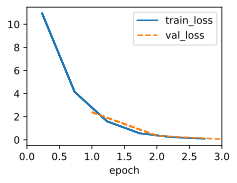

In [19]:
from d2l import torch as d2l
model = d2l.LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

Next, let's try a smaller lr

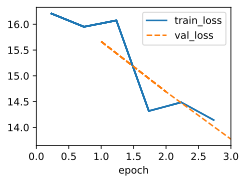

In [22]:
model = d2l.LinearRegressionScratch(2, lr=0.001)
trainer.fit(model, data)

We can find that the initial loss is bigger, and the loss value drop after 3 epochs is smaller than the case with lr of 0.03, indicating that the param updating amplitude is smaller.

Then let's try a bigger lr

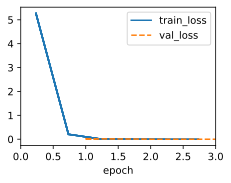

In [23]:
model = d2l.LinearRegressionScratch(2, lr=0.1)
trainer.fit(model, data)

We can find that with bigger lr, the loss will drop faster. Though it remains at approximately 0 in this case(probably due to the simplicity of the problem and the model), the loss value may fluctuate with bigger lr in complex real problems. 

Back to the initial lr, let's increase the max_epoch to see if the error will decrease.

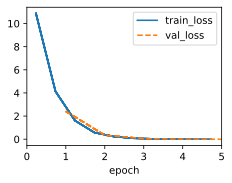

In [24]:
model = d2l.LinearRegressionScratch(2, lr=0.03)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

We can see that the error won't decrease much more even if the max_epoch is set to a larger value. But this is probably because the loss value is already very small(nearly zero). 

The case will be different if the loss value is larger. Let's look at the case when lr=0.001

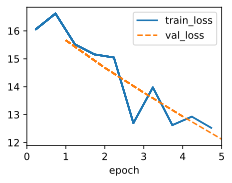

In [25]:
model = d2l.LinearRegressionScratch(2, lr=0.001)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

As we can see through the graph, the loss value continues declining for bigger max_epoch.

## 7. If the number of examples cannot be divided by the batch size, what happens to `data_iter` at the end of an epoch?

If use torch.utils.data.DataLoader: Depending on whether you set the `drop_last` or not. If `drop_last` is set to `True`, the last batch will be dropped if it can not be divieded by  batch size. If `drop_last` is set to `False`, the last batch will be returned, but smaller.

If use python slicing: Possibly the indices of the last batch will out of the bound, causing an error.

## 8. Try implementing a different loss function, such as the absolute value loss `(y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()`.

1. Check what happens for regular data.
2. Check whether there is a difference in behavior if you actively perturb some entries, such as $y_5 = 10000$, of $\mathbf{y}$.
3. Can you think of a cheap solution for combining the best aspects of squared loss and absolute value loss?
       Hint: how can you avoid really large gradient values?

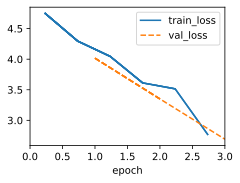

In [47]:
from d2l import torch as d2l
import torch

class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)
        
    def forward(self, X):
        return torch.matmul(X, self.w) + self.b
    
    def loss(self, y_hat, y):
        l = (y_hat - y.reshape(y_hat.shape)).abs().sum() / 32
        return l
    
    def configure_optimizers(self):
        return SGD([self.w, self.b], self.lr)

model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)
    

As we can see, the loss can normally decrease, but the drop rate of loss is actually smaller.

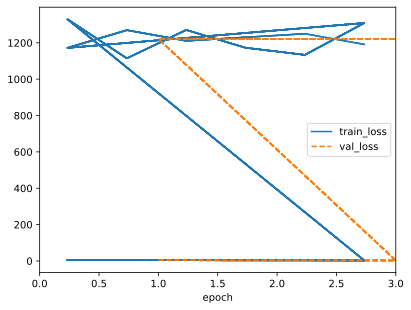

In [49]:
class SyntheticRegressionData(d2l.DataModule):
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise
        for i in range(0, len(self.y), 8):
            self.y[i] = 10000 # add 1 outlier for every 8 data points
        
    
    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size,
                                            shuffle=train)
    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)

data = SyntheticRegressionData(w=torch.tensor([2.0, -3.4, ]), b=1.2)
trainer.fit(model, data)


As we can see, the existence of outlier severely affects the training of the model.

# 9. Why do we need to reshuffle the dataset? Can you design a case where a maliciously constructed dataset would break the optimization algorithm otherwise?